# Forecasting Sales with Machine Learning Models 

Time series forecasting is the process of analyzing **historical data** using statistics and modeling to **predict future values**. Time series data adds an explicit order dependence between observations: a time dimension.

Machine learning is field of AI that uses **statistical techniques** to give computer systems the **ability to learn** e.g. progressively improve performance on a specific task from data, without being explicitly programmed.

In [0]:
%pip install xgboost tensorflow -q

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Import Python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import mlflow

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from pyspark.sql.functions import col, collect_list, struct
from pyspark.sql.window import Window

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

2024-07-23 15:50:50.748477: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 15:50:50.754917: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 15:50:50.770598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 15:50:50.797416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 15:50:50.804912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 15:50:50.834107: I tensorflow/core/platform/cpu_feature_gu

## I. Data Preprocessing and Feature Engineering
**Data preprocessing** involves cleaning and preparing raw data to facilitate feature engineering. 
- **Normalization** is the process of scaling numeric features to a standard range, typically between 0 and 1. This ensures that all features contribute equally to the model.
- **Categorical data** needs to be converted into numerical format for machine learning algorithms. Encoding techniques them into a format that algorithms can understand.
- **Handling Missing Data** is essential for robust model performance. Strategies include removing rows with missing values or imputing missing values with statistical measures.

**Feature engineering** is the process of transforming and raw data into into a format suitable for machine learning models and selecting relevant features to optimize performance.

- **Creation of derived features** enhances the predictive power of the model.
- **Dimensionality reduction** is improtant because high-dimensional datasets may suffer from the curse of dimensionality, leading to increased computational complexity and potential overfitting. 
- **Handling outliers** prevents the distortion of model training. Techniques such as trimming or transforming features can mitigate the impact of outliers on model performance.

In [0]:
# Read the table from the CSV (comma-separated values) file in Unity Catalog 
df = spark.read.format("csv").option("delimiter", ",").table("hive_metastore.default.tpa_uk")

# Convert Spark DataFrame to Pandas DataFrame
df = df.toPandas()

# Display the first 5 (default) rows of the DataFrame
df.head()

Level8Code  ... ActualEventSpend
0    10364323  ...       5000.10000
1      447000  ...         17.55584
2      447000  ...         17.55584
3      447000  ...         17.55583
4      447000  ...         17.55583

[5 rows x 61 columns]

In [0]:
# Check for null values and determine the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279007 entries, 0 to 279006
Data columns (total 61 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Level8Code                         279007 non-null  int64  
 1   Customer                           279007 non-null  object 
 2   PromoIDText                        279007 non-null  object 
 3   PromoFlag                          279007 non-null  object 
 4   TUEAN                              279007 non-null  int64  
 5   WeekSkID                           279007 non-null  object 
 6   InStoreStartWeek                   279007 non-null  float64
 7   InStoreEndWeek                     279007 non-null  float64
 8   PromotionStatus                    279007 non-null  object 
 9   InstoreStartDate                   279007 non-null  object 
 10  InstoreEndDate                     279007 non-null  object 
 11  ShipmentStartDate                  2790

In [0]:
# Fill in null values with zeroes (both 'null' strings and NaNs) and cast columns into floats
object_to_float_columns = []
df[object_to_float_columns] = df[object_to_float_columns].replace('null', 0).fillna(0).astype(float)

# Fill in null values and cast columns into strings/objects
int_to_object_columns = ['InStoreStartWeek','InStoreEndWeek']
df[int_to_object_columns] = df[int_to_object_columns].fillna('null').astype(str)

# Create a new column with the calculated Actual Incremental Gross Profit (ActualIGP)
df['ActualIGP'] = (df['ActualNetPromoGrossProfitsSellOut'] - df['ActualBaseGrossProfitsSellOut']).astype(float)
# Extract the year and week from the 'WeekSKID' column
df.loc[:, 'Year'] = df['WeekSkID'].str[:4].astype(int)
df.loc[:, 'Week'] = df['WeekSkID'].str[-2:].astype(int)

# Identify the categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_df = df[categorical_columns]
numerical_df = df[numerical_columns]
print(f"Categorical Columns:\n{categorical_columns}")
print(f"Numerical Columns:\n{numerical_columns}")

Categorical Columns:
['Customer', 'PromoIDText', 'PromoFlag', 'WeekSkID', 'InStoreStartWeek', 'InStoreEndWeek', 'PromotionStatus', 'InstoreStartDate', 'InstoreEndDate', 'ShipmentStartDate', 'ShipmentEndDate', 'PromoFeature', 'PromoMechanic', 'PromoShopperMechanic', 'DivisionName_VG', 'CategoryName_VG', 'SegmentName_VG', 'FormName_VG', 'EBFName_VG', 'Brand_VG', 'SPF', 'SPFVName_VG', 'PlannedPromoSalesVolumeSellIn', 'PlannedNetPromoGSVSellIn', 'PlannedTTSOnSpend', 'PlannedNetPromoNIVSellIn', 'PlannedTTSOffSpend', 'PlannedNetPromoTOSellIn', 'PlannedNetPromoGrossProfitsSellIn', 'PlannedNetPromoCOGSSellIn', 'PlannedEventSpend']
Numerical Columns:
['Level8Code', 'TUEAN', 'ListPrice', 'PlannedBaselineVolume', 'PlannedBaseGSVSellIn', 'PlannedBaseTTSOnSpend', 'PlannedBaseNIVSellIn', 'PlannedBaseTTSOffSpend', 'PlannedBaseTOSellIn', 'PlannedBaseGrossProfitsSellIn', 'PlannedBaseCOGSSellIn', 'ActualPromoSalesValueSellOut', 'ActualPromoSalesVolumeSellOut', 'ActualNetPromoGSVSellOut', 'ActualTTSOnSpe

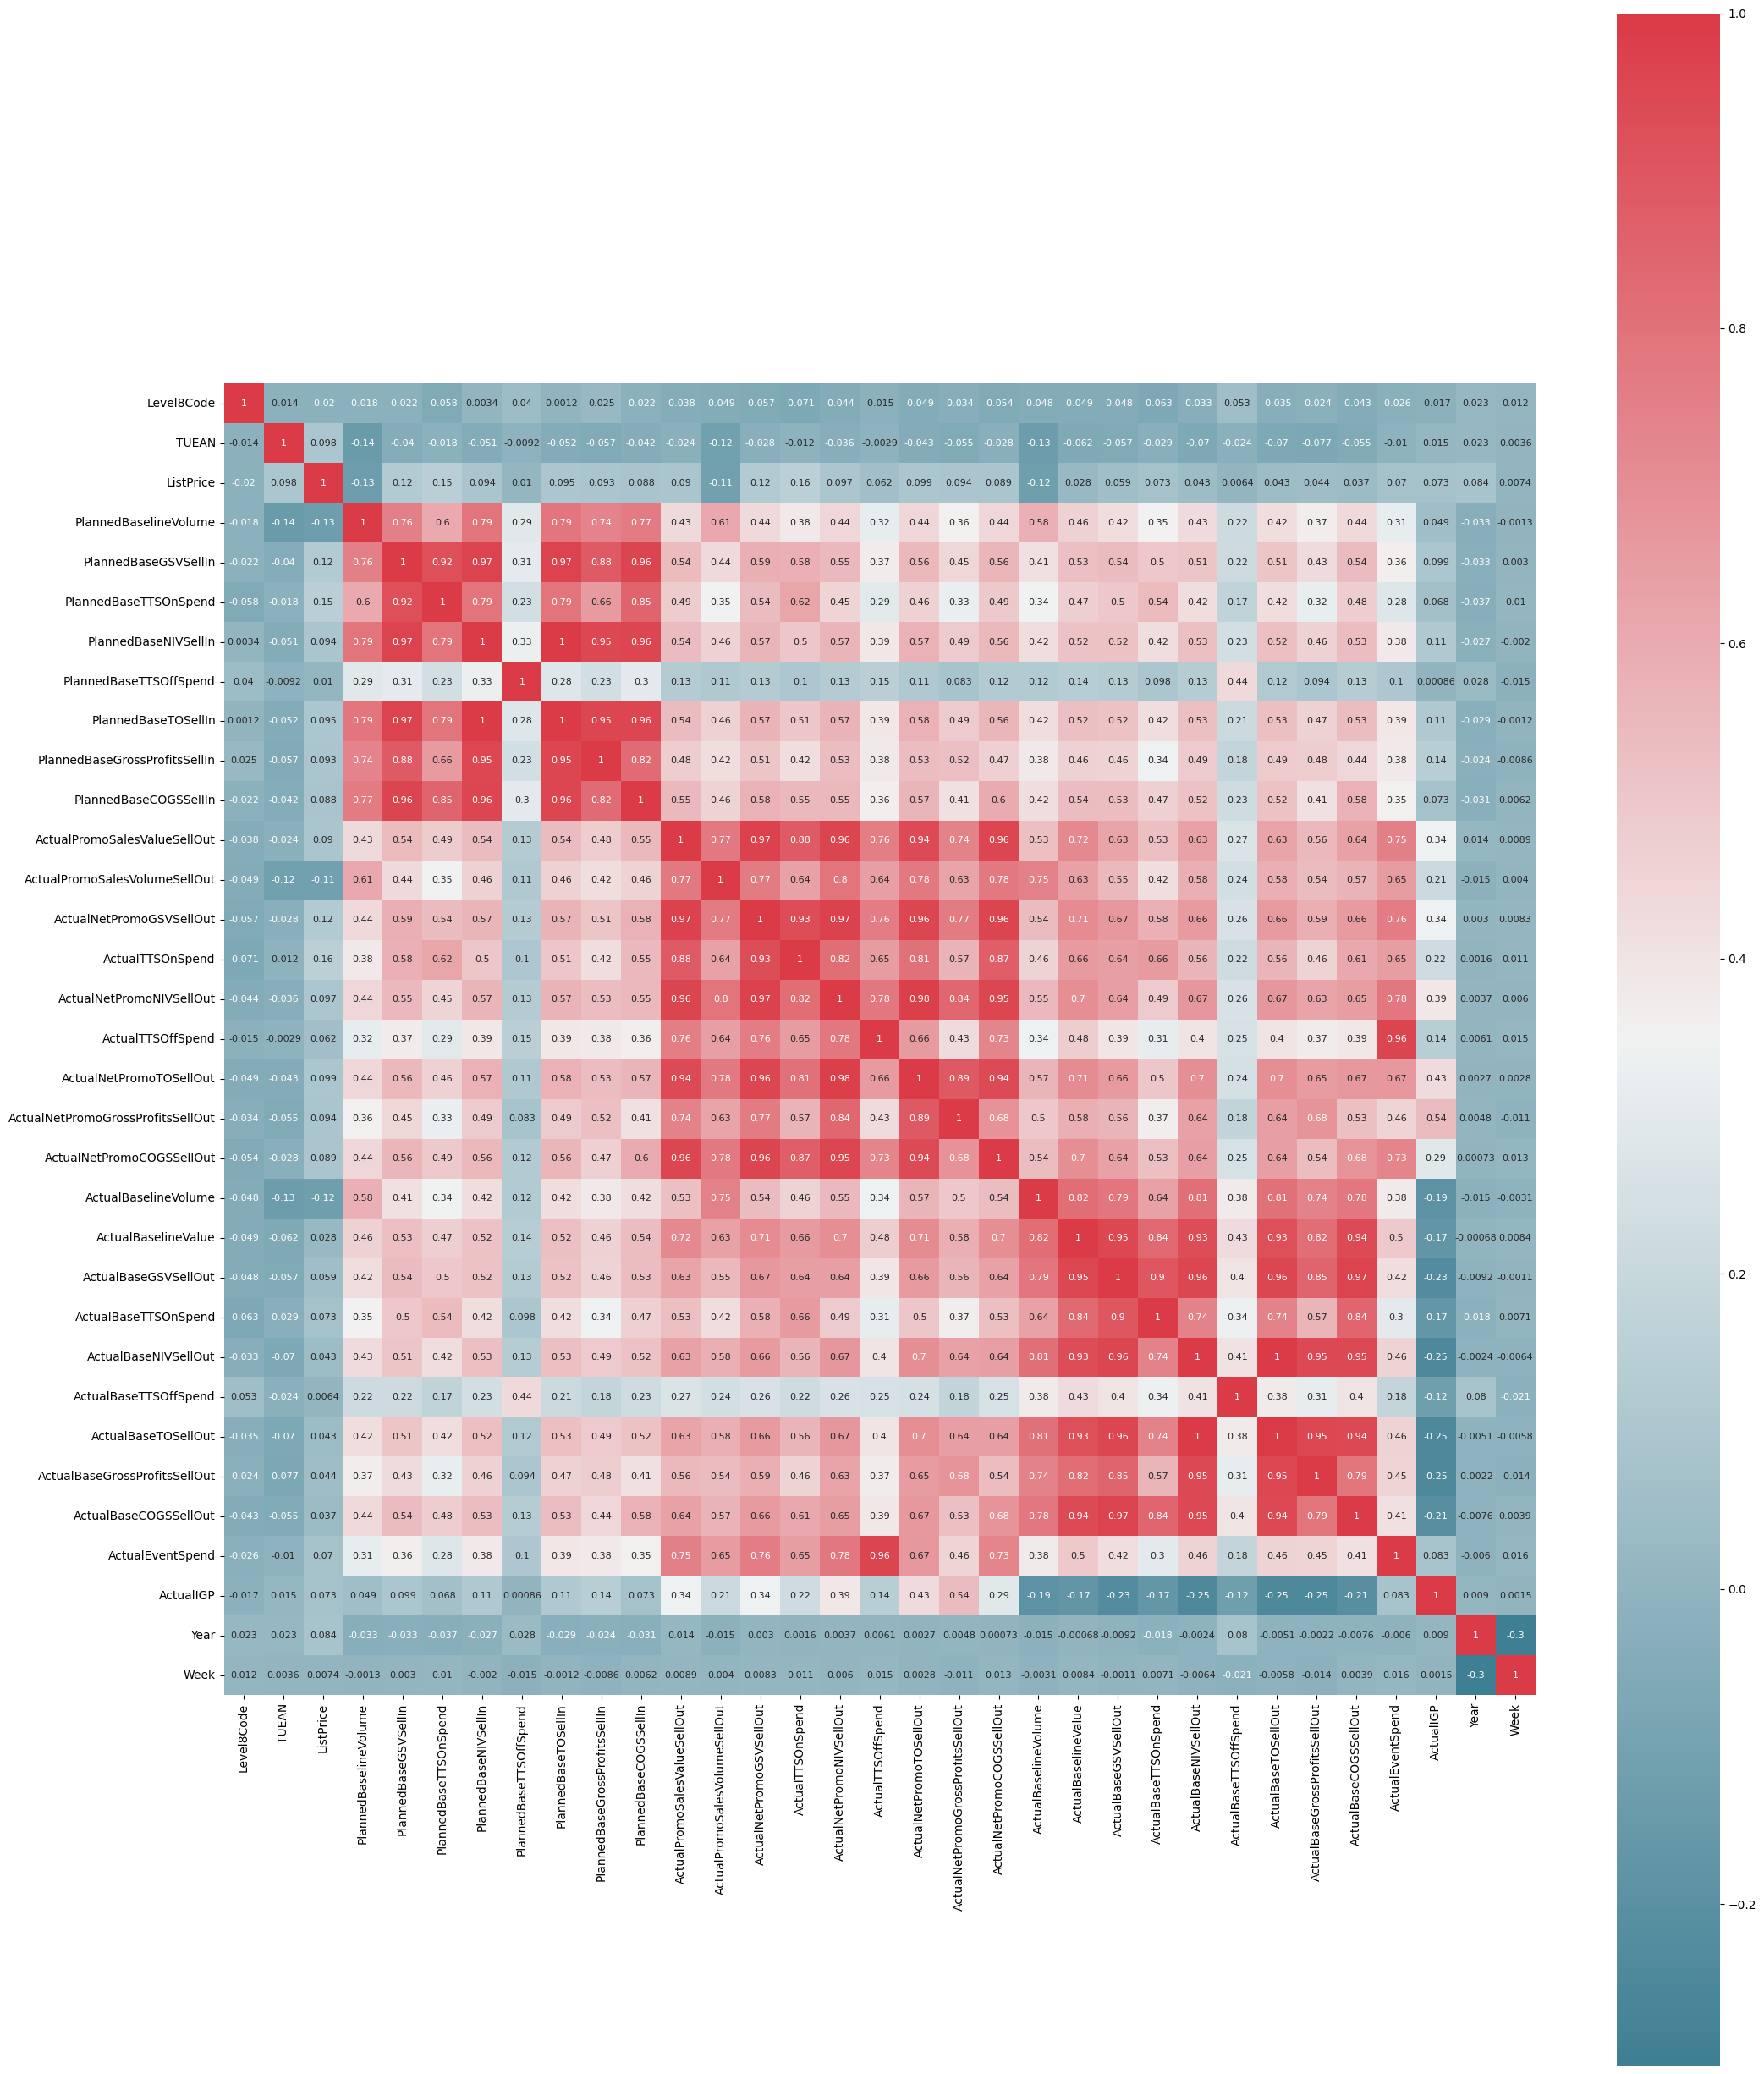

In [0]:
# Create a subplot with a figure size of 25 inches by 35 inches
color_map, axis = plt.subplots (figsize = (25,35))
# Calculate the correlation matrix for the specified numerical columns in the DataFrame' using Pearson's method
correlation_matrix = numerical_df.corr(method = 'pearson')
# Create a diverging color palette for the heatmap
# Create a heatmap to visualize the correlation matrix
# cmap - Use the diverging color palette created above
# square - Make the cells square
# cbar_kws - Add a color bar with a shrink factor of 0.9
# ax - Use the specified axis for the plot
# annot - Annotate the cells with the correlation values
# annot_kws - Set the font size for the annotations to 8
cmap = sns.diverging_palette(220,10, as_cmap = True)
_ = sns.heatmap (correlation_matrix, cmap = cmap, square = True, cbar_kws={
    'shrink' : .9}, ax=axis, annot = True, annot_kws = {'fontsize':8})

In [0]:
# Calculate correlations of the numerical data with the target column
correlations = df[numerical_columns].corrwith(df['ActualPromoSalesVolumeSellOut'])
# Rank the correlations by their absolute values
ranked_correlations = correlations.abs().sort_values(ascending=False)
# Display the ranked correlations
ranked_correlations

ActualPromoSalesVolumeSellOut        1.000000
ActualNetPromoNIVSellOut             0.795623
ActualNetPromoCOGSSellOut            0.779996
ActualNetPromoTOSellOut              0.777515
ActualPromoSalesValueSellOut         0.774448
ActualNetPromoGSVSellOut             0.767759
ActualBaselineVolume                 0.746398
ActualEventSpend                     0.651928
ActualTTSOffSpend                    0.641201
ActualTTSOnSpend                     0.635984
ActualBaselineValue                  0.633091
ActualNetPromoGrossProfitsSellOut    0.626196
PlannedBaselineVolume                0.612568
ActualBaseNIVSellOut                 0.584809
ActualBaseTOSellOut                  0.584597
ActualBaseCOGSSellOut                0.569580
ActualBaseGSVSellOut                 0.552975
ActualBaseGrossProfitsSellOut        0.538112
PlannedBaseTOSellIn                  0.462550
PlannedBaseNIVSellIn                 0.460802
PlannedBaseCOGSSellIn                0.460684
PlannedBaseGSVSellIn              

In [0]:
columns_to_drop=['PromoFlag', 'PromotionStatus', 'InstoreStartDate', 'InstoreEndDate', 'ShipmentStartDate', 'ShipmentEndDate', 'WeekSkID']
one_hot_encoder_values = ['Customer', 'DivisionName_VG', 'CategoryName_VG', 'SegmentName_VG', 'FormName_VG', 'EBFName_VG', 'Brand_VG', 'SPF', 'PromoFeature', 'PromoMechanic', 'PromoShopperMechanic', 'SPFVName_VG', 'Level8Code', 'PromoIDText', 'TUEAN']
ordinal_encoder_values = [ 'InStoreStartWeek', 'InStoreEndWeek', 'Week', 'Year']
numerical_values = ['ListPrice',  'PlannedNetPromoGSVSellIn', 'PlannedTTSOnSpend', 'PlannedNetPromoNIVSellIn', 'PlannedTTSOffSpend', 'PlannedNetPromoTOSellIn', 'PlannedNetPromoGrossProfitsSellIn', 'PlannedNetPromoCOGSSellIn', 'PlannedBaselineVolume', 'PlannedBaseGSVSellIn', 'PlannedBaseTTSOnSpend', 'PlannedBaseNIVSellIn', 'PlannedBaseTTSOffSpend', 'PlannedBaseTOSellIn', 'PlannedBaseGrossProfitsSellIn', 'PlannedBaseCOGSSellIn', 'PlannedEventSpend', 'ActualPromoSalesValueSellOut', 'ActualNetPromoGSVSellOut', 'ActualNetPromoNIVSellOut', 'ActualTTSOffSpend', 'ActualNetPromoTOSellOut', 'ActualNetPromoGrossProfitsSellOut', 'ActualNetPromoCOGSSellOut', 'ActualBaselineVolume', 'ActualBaselineValue', 'ActualBaseGSVSellOut', 'ActualBaseTTSOnSpend', 'ActualBaseNIVSellOut', 'ActualBaseTTSOffSpend', 'ActualBaseTOSellOut', 'ActualBaseGrossProfitsSellOut', 'ActualBaseCOGSSellOut', 'ActualEventSpend', 'ActualTTSOnSpend', 'PlannedPromoSalesVolumeSellIn', 'ActualIGP']
target_variable = ['ActualPromoSalesVolumeSellOut']

In [0]:
# Preprocess the DataFrame and split it into the testing and training sets
def preprocess(df: pd.DataFrame, columns_to_drop: np.ndarray, one_hot_encoder_values: np.ndarray, ordinal_encoder_values: np.ndarray, numerical_values: np.ndarray, target_variable: np.ndarray):

    # Drop columns that are not needed
    df_model = df.drop(columns=columns_to_drop)

    # Replace 'null' strings with NaN values
    df_model.replace('null', np.nan, inplace=True)

    # Convert numerical columns to floats and ordinal columns to strings
    for column in numerical_values:
        df_model[column] = pd.to_numeric(df_model[column], errors='coerce')
    for column in ordinal_encoder_values:
        df_model[column] = df_model[column].astype(str)

    # Drop rows with missing values
    df_model = df_model.dropna(subset=one_hot_encoder_values + ordinal_encoder_values + numerical_values + target_variable)

    # Ensure there are no infinite or excessively large values in numerical features and target
    df_model = df_model[np.isfinite(df_model[numerical_values + target_variable]).all(axis=1)]

    # Standardize the target variable helps to ensure that the target values have a mean of 0 and a standard deviation of 1
    target_scaler = StandardScaler()
    df_model[target_variable] = target_scaler.fit_transform(df_model[target_variable].values.reshape(-1, 1))

    # Define the preprocessor pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_values),
            ('cat', OneHotEncoder(handle_unknown='ignore'), one_hot_encoder_values),
            ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_encoder_values)
    ])

    # Separate the primary key columns and any other columns from the features
    # columns_to_pop = ['PromoIDText', 'WeekSkID', 'TUEAN'] 

    # Split data into features (X) and target (y) and covert the latter to the correct shape
    X = df_model[one_hot_encoder_values + ordinal_encoder_values + numerical_values]
    y = df_model[target_variable].values.ravel()

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Remove the primary key columns from the test and train set features
    # primary_key_columns_test = {}
    # for col in columns_to_pop:
    #     primary_key_columns_test[col] = X_test.pop(col).values
    #     X_train.pop(col).values

    # Fit the preprocessor and transform the training data and testing data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, y_train, y_test, preprocessor

X_train, X_test, y_train, y_test, preprocessor = preprocess(df, columns_to_drop, one_hot_encoder_values, ordinal_encoder_values, numerical_values, target_variable)

In [0]:
# Inverse transform the predictions and the target values to convert them back to their original scale
def postprocess(predictions, y_train, y_test):
     # Initialize the StandardScaler and fit it to the training target values (y_train)
    target_scaler = StandardScaler().fit(y_train.reshape(-1, 1)) 
    # Use the fitted scaler to inverse transform the predictions
    inverse_predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1))
    # Use the fitted scaler to inverse transform the test target values (y_test)
    inverse_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    # Return the inverse transformed predictions and test target values
    return inverse_predictions, inverse_y_test

## II. Building Machine Learning Models with Scikit-Learn
Scikit-Learn is a free **machine learning library** for Python. It supports both supervised and unsupervised machine learning, providing diverse algorithms for classification, regression, clustering, and dimensionality reduction.

In [0]:
# Calculate simple error
def _error(actual: np.ndarray, predicted: np.ndarray):
    return actual - predicted

# Calculate mean absolute error
def mae(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.abs(_error(actual, predicted)), axis=0)

# Calculate mean squared error
def mse(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.square(_error(actual, predicted)), axis=0)

# Calculate root mean squared error
def rmse(actual: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mse(actual, predicted))

# Calculate forecast bias (mean forecast error)
def bias(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(actual - predicted)

METRICS = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "bias": bias
}

# Create a function to evaluate the model based on each metric
def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "mse", "rmse", "bias")):
    results = {}
    for metric in metrics:
        try:
            results[metric] = METRICS[metric](actual, predicted)
        except Exception as err:
            results[metric] = np.nan
            print("ERROR Unable to compute {0}: {1}".format(metric, err))
    return results

# Initialize the dictionaries to store the results and predictions
results = {}
predictions = {}

### 1. Random Forest
A random forest is a machine learning algorithm that combines an ensemble of  **decision trees** (forest) to create a singular output. Each tree is constructed using a random subset of the data in order to measure a random subset of features within each partition. The algorithm aggregates the results of all the trees by taking their average.

In [0]:
def random_forest(X_train, X_test, y_train, y_test):
  # Initialize the RandomForestRegressor model with 100 trees, a maximum depth of 10, and a random state of 0
  rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10, 
    random_state=0
  )
  # Fit the RandomForestRegressor model to the training data
  rf_model.fit(X_train, y_train)
  # Predict the target values for the test data
  rf_predictions = rf_model.predict(X_test)
  # Inverse transform the predictions and the test target values using the postprocess function
  inverse_predictions, inverse_y_test = postprocess(rf_predictions, y_train, y_test)
  # Evaluate the model's performance and store the results
  results['RandomForest'] = evaluate(inverse_y_test, inverse_predictions)
  predictions['RandomForest'] = inverse_predictions
  return rf_model, inverse_y_test
rf_model, inverse_y_test = random_forest(X_train, X_test, y_train, y_test)

Text(0.5, 1.0, 'Original Versus Predicted Sales Volume')

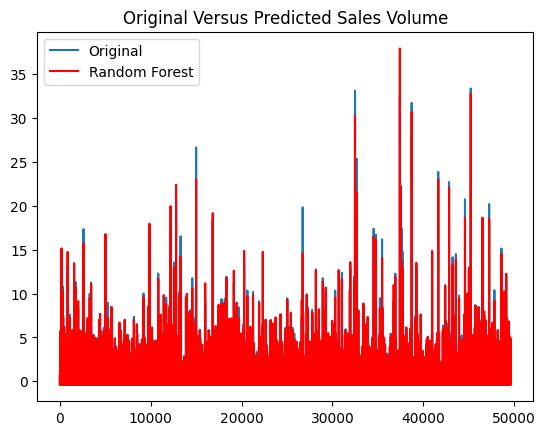

In [0]:
# Plot the original test target values
plt.plot(inverse_y_test, label='Original')
# Plot the predictions from the Random Forest model
plt.plot(predictions['RandomForest'], color='red', label='Random Forest')
# Add a legend to the plot to differentiate between the original and predicted values
plt.legend()
plt.title('Original Versus Predicted Sales Volume')

### 2. XGBoost
XGBoost is a machine learning algorithm that uses **gradient boosted decision trees**, a supervised learning boosting algorithm that makes use of gradient descent. Gradient descent is an optimization algorithm that is based on a convex function and tweaks its parameters iteratively to minimize a given function to its local minimum.

In [0]:
def xgboost(X_train, X_test, y_train, y_test):
    # Initialize the XGBoost model with 100 trees, a maximum depth of 10, and the squared error objective
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        objective='reg:squarederror',
    )
    # Fit the XGBoost model to the training data
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    # Predict the target values for the test data
    xgb_predictions = xgb_model.predict(X_test)
    # Inverse transform the predictions and the test target values using the postprocess function
    inverse_predictions, inverse_y_test = postprocess(xgb_predictions, y_train, y_test)
    # Evaluate the model's performance and store the results
    results['XGBoost'] = evaluate(inverse_y_test, inverse_predictions)
    predictions['XGBoost'] = inverse_predictions
    return xgb_model, inverse_y_test

xgb_model, inverse_y_test = xgboost(X_train, X_test, y_train, y_test)

Text(0.5, 1.0, 'Original Versus Predicted Sales Volume')

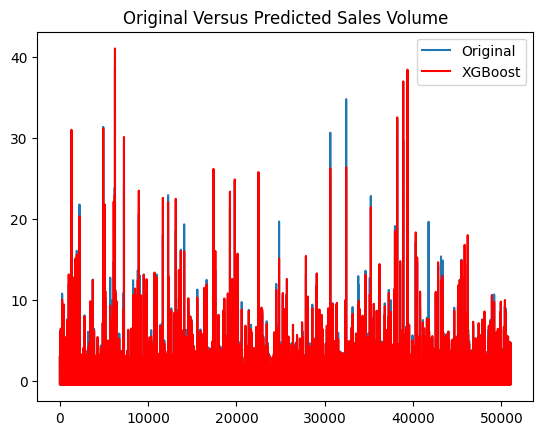

In [0]:
# Plot the original test target values
plt.plot(inverse_y_test, label='Original')
# Plot the predictions from the XGBoost model
plt.plot(predictions['XGBoost'], color='red', label='XGBoost')
# Add a legend to the plot to differentiate between the original and predicted values
plt.legend()
plt.title('Original Versus Predicted Sales Volume')

## III. Building Deep Learning Models with TensorFlow

Deep learning is a subset of machine learning that uses **multilayered neural networks**, called deep neural networks, to simulate the complex decision-making power of the human brain. 


### 1. Deep Neural Network
A Deep Neural Network (DNN) is a type of **artificial neural network** (ANN) with multiple layers between the input and output layers. These networks are called "deep" because they have more than one hidden layer. DNNs are capable of modeling complex patterns in data and are the foundation of many modern machine learning applications.



In [0]:
def dnn(X_train, X_test, y_train, y_test):
    # Build the neural network model
    dnn_model = Sequential()
    dnn_model.add(Input(shape=(X_train.shape[1],)))  # Explicit Input layer
    dnn_model.add(Dense(128, activation='relu'))
    dnn_model.add(Dense(64, activation='relu'))
    dnn_model.add(Dense(32, activation='relu'))
    dnn_model.add(Dense(1, activation='linear'))
    # Compile the model
    dnn_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    # Fit the DNN model to the training data
    history = dnn_model.fit(X_train, y_train, epochs=70, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    # Evaluate the model
    loss = dnn_model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    # Predict the target values for the test data
    dnn_predictions = dnn_model.predict(X_test)
    # Inverse transform the predictions and the test target values using the postprocess function
    inverse_predictions, inverse_y_test = postprocess(dnn_predictions, y_train, y_test)
    # Evaluate the model's performance and store the results
    results['DNN'] = evaluate(inverse_y_test, inverse_predictions)
    predictions['DNN'] = inverse_predictions
    return dnn_model, inverse_y_test, history

dnn_model, inverse_y_test, history = dnn(X_train, X_test, y_train, y_test)

2024-07-22 05:33:52.362836: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 140712208 exceeds 10% of free system memory.


Epoch 1/70
2360/5108 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss

*** WARNING: max output size exceeded, skipping output. ***

5108/5108 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0073 - val_loss: 0.0109
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0066
Test Loss: 0.006780465133488178
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [0]:
dnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       432,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,029 (5.07 MB)

 Trainable params: 443,009 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 886,020 (3.38 MB)

Text(0.5, 1.0, 'Original Versus Predicted Sales Volume')

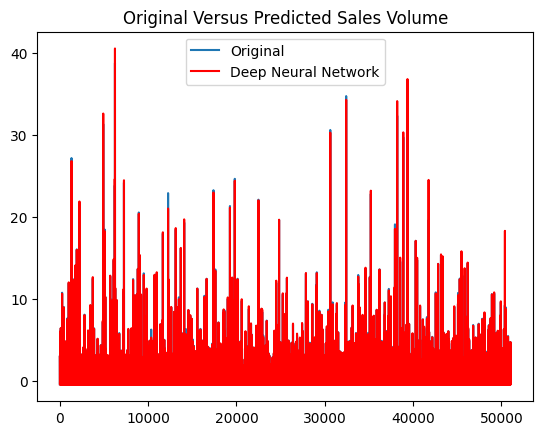

In [0]:
# Plot the original test target values
plt.plot(inverse_y_test, label='Original')
# Plot the predictions from the DNN model
plt.plot(predictions['DNN'], color='red', label='Deep Neural Network')
# Add a legend to the plot to differentiate between the original and predicted values
plt.legend()
plt.title('Original Versus Predicted Sales Volume')

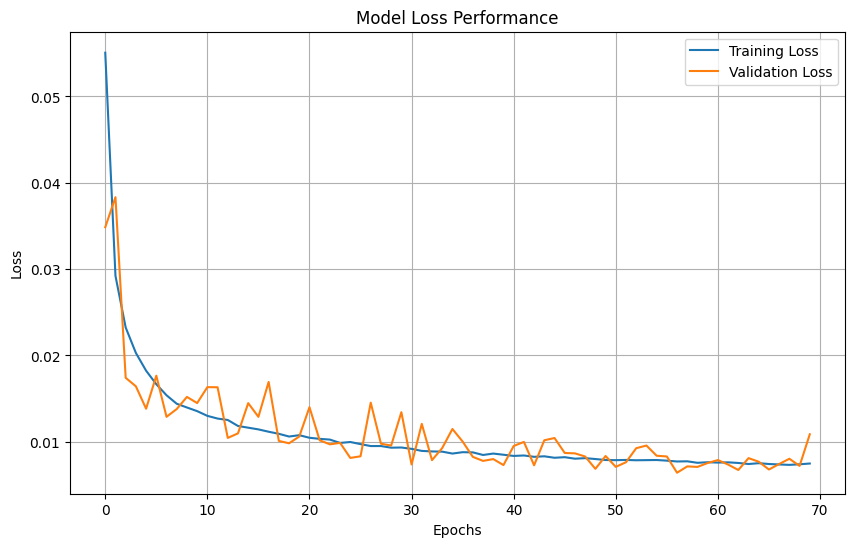

In [0]:
# Plotting the loss performance
plt.figure(figsize=(10, 6))
# Plot the training loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
# Plot the validation loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Add a grid to the plot for better readability
plt.grid(True)
plt.show()

## III. Model Evaluation
Model evaluation is the process of using some metrics to **analyze the performance of the model**. It is important in machine learning because it determines the best-performing models, increases accuracy, prevents overfitting, helps achieve organizational goals, and prevents risks

In [0]:
# Loop over each model and print its corresponding metrics
for model, metrics in results.items():
    print(model)
    for metric in metrics:
        print(f'{metric}:{metrics[metric]}')
    print("\n")

DNN
mae:[0.00668987]
mse:[0.00427383]
rmse:[0.06537457]
bias:-0.001790966658552347


RandomForest
mae:[0.01404126]
mse:[0.00634835]
rmse:[0.0796765]
bias:0.0010455423179665828


XGBoost
mae:[0.01204477]
mse:[0.01692557]
rmse:[0.13009831]
bias:-0.00044337853789330165




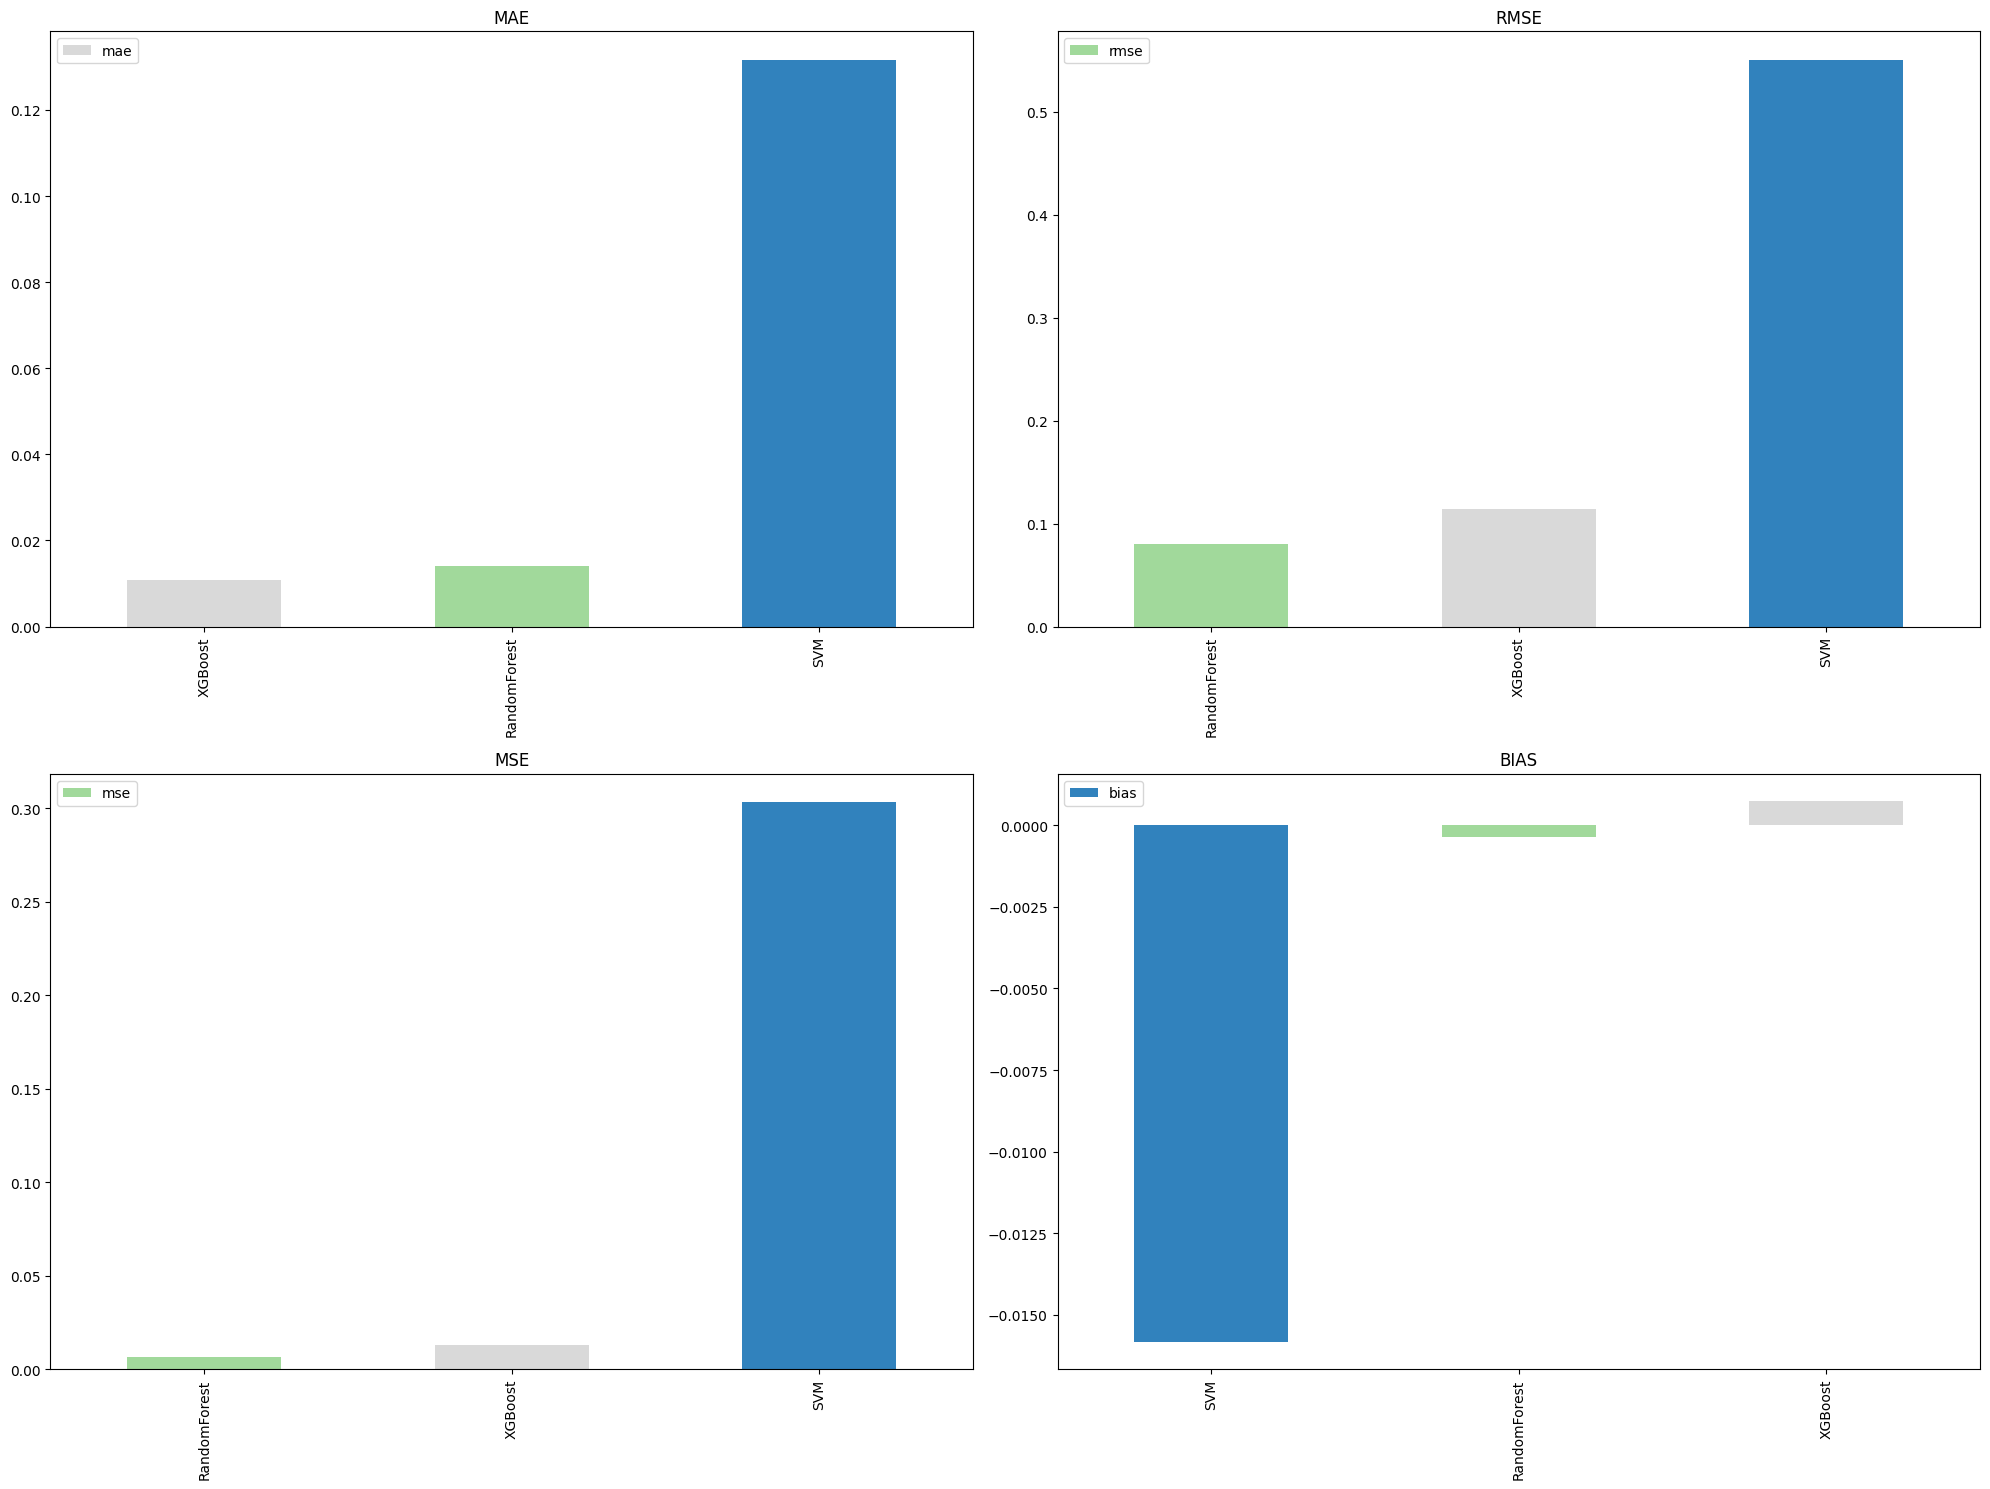

In [0]:
def plot_bar_metrics(results, metrics=["mae","rmse","mse", "bias"]):
    # Convert the results dictionary to a DataFrame
    df = pd.DataFrame.from_dict(results)
    # Get the default color cycle from Matplotlib
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Create a color palette with a specified number of colors
    pallette = plt.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    # Create a dictionary mapping each column to a color
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))
    # Initialize the subplot index
    idx = 1
    # Loop through each metric in the metrics list
    for metric in metrics:
        # Add a subplot to the figure
        fig.add_subplot(2, 2, idx)
        # Plot the sorted values of the metric as a bar chart
        df.loc[metric].sort_values().plot(
            kind="bar",
            color=[color_dict.get(x, "#333333") for x in df.loc[metric].sort_values().index],
        )
        plt.legend()
        # Set the title of the plot to the uppercase metric name
        plt.title(metric.upper())
        # Increment the subplot index
        idx+=1
    plt.tight_layout()
    plt.show()

# Call the function to plot the bar metrics
plot_bar_metrics(results)

#### Generating a Submission File
Generate a CSV file with a table containing the primary key (**PromoIDText**, **WeekSkID**, and **TUEAN**) and your predictions (**ActualPromoSalesVolumeSellOut**).

In [0]:
# Preprocess the DataFrame and split it into the testing and training sets
def preprocess_validation(df: pd.DataFrame, columns_to_drop: np.ndarray, one_hot_encoder_values: np.ndarray, ordinal_encoder_values: np.ndarray, numerical_values: np.ndarray):
    # Add new features - Actual Incremental Gross Profit (ActualIGP), Year, and Week
    df['ActualIGP'] = (df['ActualNetPromoGrossProfitsSellOut'] - df['ActualBaseGrossProfitsSellOut']).astype(float)
    df.loc[:, 'Year'] = df['WeekSkID'].str[:4].astype(int)
    df.loc[:, 'Week'] = df['WeekSkID'].str[-2:].astype(int)

    # Drop columns that are not needed
    df_model = df.drop(columns=columns_to_drop)

    # Replace 'null' strings with NaN values
    df_model.replace('null', np.nan, inplace=True)

    # Convert numerical columns to floats and ordinal columns to strings
    for column in numerical_values:
        df_model[column] = pd.to_numeric(df_model[column], errors='coerce')
    for column in ordinal_encoder_values:
        df_model[column] = df_model[column].astype(str)

    # Drop rows with missing values
    df_model = df_model.dropna(subset=one_hot_encoder_values + ordinal_encoder_values + numerical_values)

    # Ensure there are no infinite or excessively large values in numerical features and target
    df_model = df_model[np.isfinite(df_model[numerical_values]).all(axis=1)]

    # Define the preprocessor pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_values),
            ('cat', OneHotEncoder(handle_unknown='ignore'), one_hot_encoder_values),
            ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_encoder_values)
    ])

    X_validation = preprocessor.fit_transform(df_model)

    return X_validation

In [0]:
# Read the table from the CSV (comma-separated values) file in Unity Catalog 
validation_df = spark.read.format("csv").option("delimiter", ",").table("hive_metastore.default.tpa_uk_2024")
validation_df = validation_df.toPandas()
display(validation_df)
print(validation_df.shape)

Level8Code Customer PromoIDText PromoFlag TUEAN WeekSkID InStoreStartWeek InStoreEndWeek PromotionStatus InstoreStartDate InstoreEndDate ShipmentStartDate ShipmentEndDate PromoFeature PromoMechanic PromoShopperMechanic DivisionName_VG CategoryName_VG SegmentName_VG FormName_VG EBFName_VG Brand_VG SPF SPFVName_VG ListPrice PlannedPromoSalesVolumeSellIn PlannedNetPromoGSVSellIn PlannedTTSOnSpend PlannedNetPromoNIVSellIn PlannedTTSOffSpend PlannedNetPromoTOSellIn PlannedNetPromoGrossProfitsSellIn PlannedNetPromoCOGSSellIn PlannedBaselineVolume PlannedBaseGSVSellIn PlannedBaseTTSOnSpend PlannedBaseNIVSellIn PlannedBaseTTSOffSpend PlannedBaseTOSellIn PlannedBaseGrossProfitsSellIn PlannedBaseCOGSSellIn PlannedEventSpend ActualPromoSalesVolumeSellOut ActualBaselineVolume ActualBaselineValue 10364323 WM MORRISON SUPERMARKETS LIMITED P-00477179 WM MORRISON SUPERMA-Colmans Meal Maker Pouch x16 Meat-Week-15-18-P7 2024 Colmans DPS 16s 8711200415489 2024-16 2024.15 2024.18 Executed 2024-04-10 2024-04-30 2024-04-10 2024-04-30 Shelf Multi-Buy 4 for £2·50 FOODS CATEGORY SCRATCH COOKING AID MEALMAKER DRY MEALMAKER DRY COLMANS COLMANS COLMANS 43GR POUCH Colmans MM Chick Chass. Pou 16x43g 0.7425 1779.05152 1320.94575 309.1102 1011.83555 354.2517 657.58385 274.03035 383.5535 2300.96 1708.4628 399.7918 1308.671 44.00336 1264.66764 768.59361 496.07403 320.22927 2112.0 1410.15 1396.0485 10364323 WM MORRISON SUPERMARKETS LIMITED P-00477179 WM MORRISON SUPERMA-Colmans Meal Maker Pouch x16 Meat-Week-15-18-P7 2024 Colmans DPS 16s 8711200415489 2024-15 2024.15 2024.18 Executed 2024-04-10 2024-04-30 2024-04-10 2024-04-30 Shelf Multi-Buy 4 for £2·50 FOODS CATEGORY SCRATCH COOKING AID MEALMAKER DRY MEALMAKER DRY COLMANS COLMANS COLMANS 43GR POUCH Colmans MM Chick Chass. Pou 16x43g 0.7425 1832.96208 1360.97434 318.47717 1042.49717 361.04584 681.45133 286.27502 395.17631 1643.54288 1220.33059 285.56558 934.76501 27.89748 906.86753 552.52893 354.3386 329.93317 1020.5 503.62857 498.59229 10364323 WM MORRISON SUPERMARKETS LIMITED P-00477179 WM MORRISON SUPERMA-Colmans Meal Maker Pouch x16 Meat-Week-15-18-P7 2024 Colmans DPS 16s 8711200415489 2024-18 2024.15 2024.18 Executed 2024-04-10 2024-04-30 2024-04-10 2024-04-30 Shelf Multi-Buy 4 for £2·50 FOODS CATEGORY SCRATCH COOKING AID MEALMAKER DRY MEALMAKER DRY COLMANS COLMANS COLMANS 43GR POUCH Colmans MM Chick Chass. Pou 16x43g 0.7425 0 0 0 0 0 0 0 0 321.45824 238.68274 55.85337 182.82937 6.14754 176.68183 107.37725 69.30459 0 0.34738 0.08 0.0792 10364323 WM MORRISON SUPERMARKETS LIMITED P-00474865 WM MORRISON SUPERMA-Radox Bath 6x500ml-Week-5-7-Charity Event Radox Bath 500ml 5000231070129 2024-06 2024.05 2024.07 Executed 2024-01-29 2024-02-18 2024-01-15 2024-02-18 Event TPR TPR £1·50 HPC CATEGORY SKIN CLEANSING BATH ADDITIVE BATH LIQUID RADOX BATH LIQ RADOX RADOX BALIQ 500ML RADOX BATH MUSCLE THERAPY 500ml REP 2.07833 5097.474 10594.25013 5318.36454 5275.88559 772.48746 4503.39813 1976.5123 2526.88583 4769.478 9912.56511 4976.15538 4936.40973 722.7819 4213.62783 1849.33399 2364.29384 0 4374.0 4105.69 6158.535 10364323 WM MORRISON SUPERMARKETS LIMITED P-00474865 WM MORRISON SUPERMA-Radox Bath 6x500ml-Week-5-7-Charity Event Radox Bath 500ml 5000231070129 2024-05 2024.05 2024.07 Executed 2024-01-29 2024-02-18 2024-01-15 2024-02-18 Event TPR TPR £1·50 HPC CATEGORY SKIN CLEANSING BATH ADDITIVE BATH LIQUID RADOX BATH LIQ RADOX RADOX BALIQ 500ML RADOX BATH MUSCLE THERAPY 500ml REP 2.07833 5499.582 11429.96459 5737.89722 5692.06737 814.10535 4877.96202 2151.74589 2726.21613 5020.644 10434.57178 5238.20524 5196.36654 743.20796 4453.15858 1964.3584 2488.80017 0 4333.0 4105.69 6158.535 10364323 WM MORRISON SUPERMARKETS LIMITED P-00474865 WM MORRISON SUPERMA-Radox Bath 6x500ml-Week-5-7-Charity Event Radox Bath 500ml 5000231070129 2024-07 2024.05 2024.07 Executed 2024-01-29 2024-02-18 2024-01-15 2024-02-18 Event TPR TPR £1·50 HPC CATEGORY SKIN CLEANSING BATH ADDITIVE BATH LIQUID RADOX BATH LIQ RADOX RADOX BALIQ 500ML RADOX BAT

(42660, 45)


In [0]:
diff_columns_df = set(df.columns) - set(validation_df.columns)
diff_columns_validation_df = set(validation_df.columns) - set(df.columns)

print("Columns in df but not in validation_df:", diff_columns_df)
print("Columns in validation_df but not in df:", diff_columns_validation_df)

Columns in df but not in validation_df: {'ActualBaseTTSOffSpend', 'ActualTTSOnSpend', 'Year', 'ActualBaseGSVSellOut', 'ActualPromoSalesValueSellOut', 'ActualEventSpend', 'ActualNetPromoGSVSellOut', 'ActualIGP', 'ActualNetPromoCOGSSellOut', 'ActualNetPromoGrossProfitsSellOut', 'ActualNetPromoNIVSellOut', 'ActualBaseTTSOnSpend', 'ActualBaseTOSellOut', 'Week', 'ActualBaseCOGSSellOut', 'ActualBaseNIVSellOut', 'ActualTTSOffSpend', 'ActualNetPromoTOSellOut', 'ActualBaseGrossProfitsSellOut'}
Columns in validation_df but not in df: set()


In [0]:
# Read the table from the CSV (comma-separated values) file in Unity Catalog 
validation_df = spark.read.format("csv").option("delimiter", ",").table("hive_metastore.default.tpa_uk_2024")
validation_df = validation_df.toPandas()
#Preprocess the validation set
X_validation = preprocess_validation(validation_df, columns_to_drop, one_hot_encoder_values, ordinal_encoder_values, numerical_values)
# Predict the target values for the validation set
y_pred = rf_model.predict(X_validation)
# Inverse transform the predictions to convert them back to their original scale
target_scaler = StandardScaler().fit(y_train.reshape(-1, 1)) 
inverse_validation_predictions = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
primary_key_columns = validation_df[['PromoIDText', 'WeekSkID', 'TUEAN']]
submission_df = pd.DataFrame(inverse_validation_predictions, columns=['ActualPromoSalesVolumeSellOut'])
submission_df = pd.concat([submission_df, primary_key_columns.reset_index(drop=True)], axis=1)
# Save the DataFrame to a CSV file
submission_df.to_csv('submission_0.csv', index=False)

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File /databricks/python/lib/python3.11/site-packages/pandas/core/indexes/base.py:3802, in Index.get_loc(self, key, method, tolerance)
   3801 try:
-> 3802     return self._engine.get_loc(casted_key)
   3803 except KeyError as err:

File /databricks/python/lib/python3.11/site-packages/pandas/_libs/index.pyx:138, in pandas._libs.index.IndexEngine.get_loc()

File /databricks/python/lib/python3.11/site-packages/pandas/_libs/index.pyx:165, in pandas._libs.index.IndexEngine.get_loc()

File pandas/_libs/hashtable_class_helper.pxi:5745, in pandas._libs.hashtable.PyObjectHashTable.get_item()

File pandas/_libs/hashtable_class_helper.pxi:5753, in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'ActualNetPromoGrossProfitsSellOut'

The above exception was the direct cause of the following exception:

KeyError                         

## V. Appendix

### 1. Ensemble Models

Ensemble models are a machine learning approach that **combines multiple models** in the prediction process. These models are referred to as **base estimators**.

In [0]:
# Define the models to use for feature selection
models = {
    'RandomForest': rf_model,
    'XGBoost': xgb_model,
}

# Define the number of top features to evaluate
num_features_list = [10, 50, 100]

selected_results = {}
selected_predictions = {}

In [0]:
def select_features(models, X_train, X_test, y_train, y_test):
    # Loop through each model in the models dictionary
    for model_name, model in models.items():
        # Loop through each number of top features to evaluate
        for num_features in num_features_list:
            # Select the top features from the model
            selector = SelectFromModel(model, prefit=True, threshold=-np.inf, max_features=num_features)
            X_train_selected_features = selector.transform(X_train)
            X_test_selected_features = selector.transform(X_test)
            # Define the final model with optimized parameters
            final_model = xgb.XGBRegressor(
                learning_rate=0.05,
                n_estimators=100,
                max_depth=10,
                min_child_weight=1,
                gamma=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='reg:squarederror',
                nthread=4,
                scale_pos_weight=1,
                seed=27,
                reg_alpha=0.1,
                reg_lambda=1.0,
                verbosity=1
            )
            # Fit the final model on the selected features of the training data
            final_model.fit(X_train_selected_features, y_train, eval_set=[(X_test_selected_features, y_test)], verbose=False)
            # Predict the target variable for the test data
            y_pred = final_model.predict(X_test_selected_features)
            # Inverse transform the predictions and the test target values using the postprocess function
            inverse_predictions, inverse_y_test = postprocess(y_pred, y_train, y_test)
            # Evaluate the model's performance and store the results
            selected_results[(model_name, num_features)] = evaluate(inverse_y_test, inverse_predictions)
            selected_predictions[(model_name, num_features)] = inverse_predictions

select_features(models, X_train, X_test, y_train, y_test)

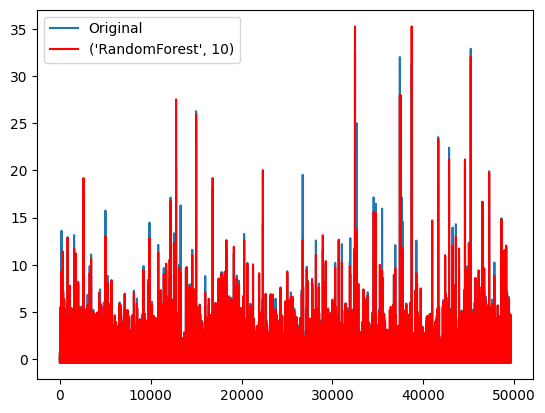

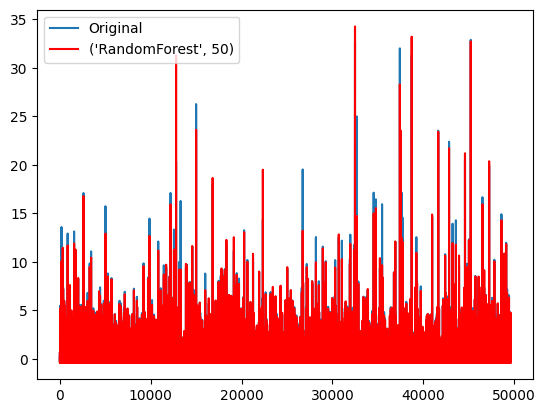

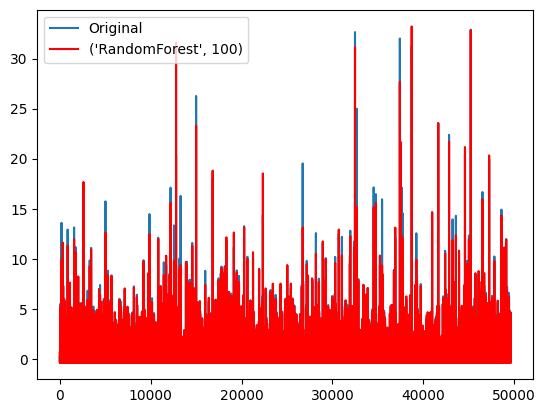

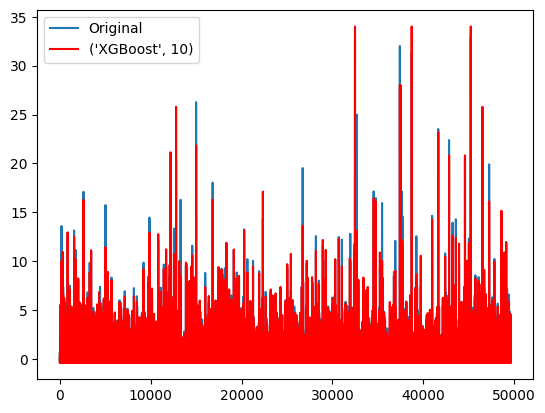

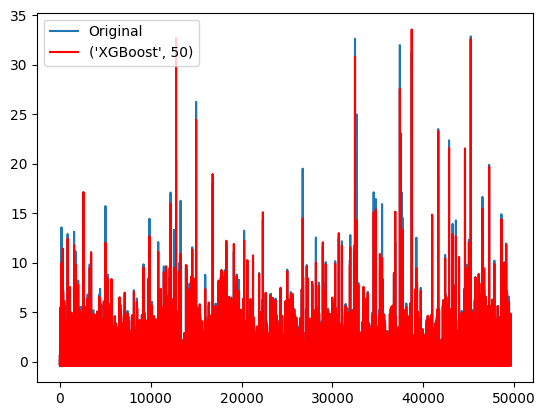

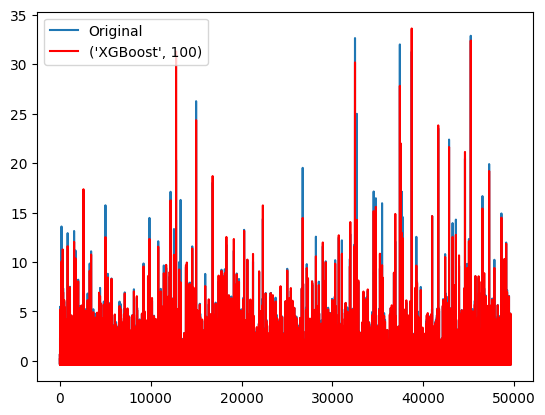

In [0]:
# Loop through each model and its corresponding predictions in the selected_predictions
for model, y_pred in selected_predictions.items():
    plt.figure()
    plt.plot(y_test, label='Original')
    plt.plot(selected_predictions[model], color='red', label=model)
    plt.legend()

In [0]:
# Loop over each model and print its corresponding metrics
for model, metrics in results.items():
    print(model)
    for metric in metrics:
        print(f'{metric}:{metrics[metric]}')
    print("\n")

('RandomForest', 10)
mae:0.014152394188224964
mse:0.013571963844800842
rmse:0.11649877185962451
bias:0.0006256348233548458


('RandomForest', 50)
mae:0.01367823823520361
mse:0.011957270834241533
rmse:0.10934930651010794
bias:0.001040542980890994


('RandomForest', 100)
mae:0.01307680315008022
mse:0.012030637635727445
rmse:0.10968426339146124
bias:0.001165053151426216


('XGBoost', 10)
mae:0.03355848102114858
mse:0.019750218228098245
rmse:0.14053546964413732
bias:0.0005986650444683067


('XGBoost', 50)
mae:0.015260545530476783
mse:0.012119059047599957
rmse:0.11008659794725222
bias:0.0006868104156962778


('XGBoost', 100)
mae:0.013492342551325273
mse:0.011821375051273515
rmse:0.10872614704510372
bias:0.0009603494101467127




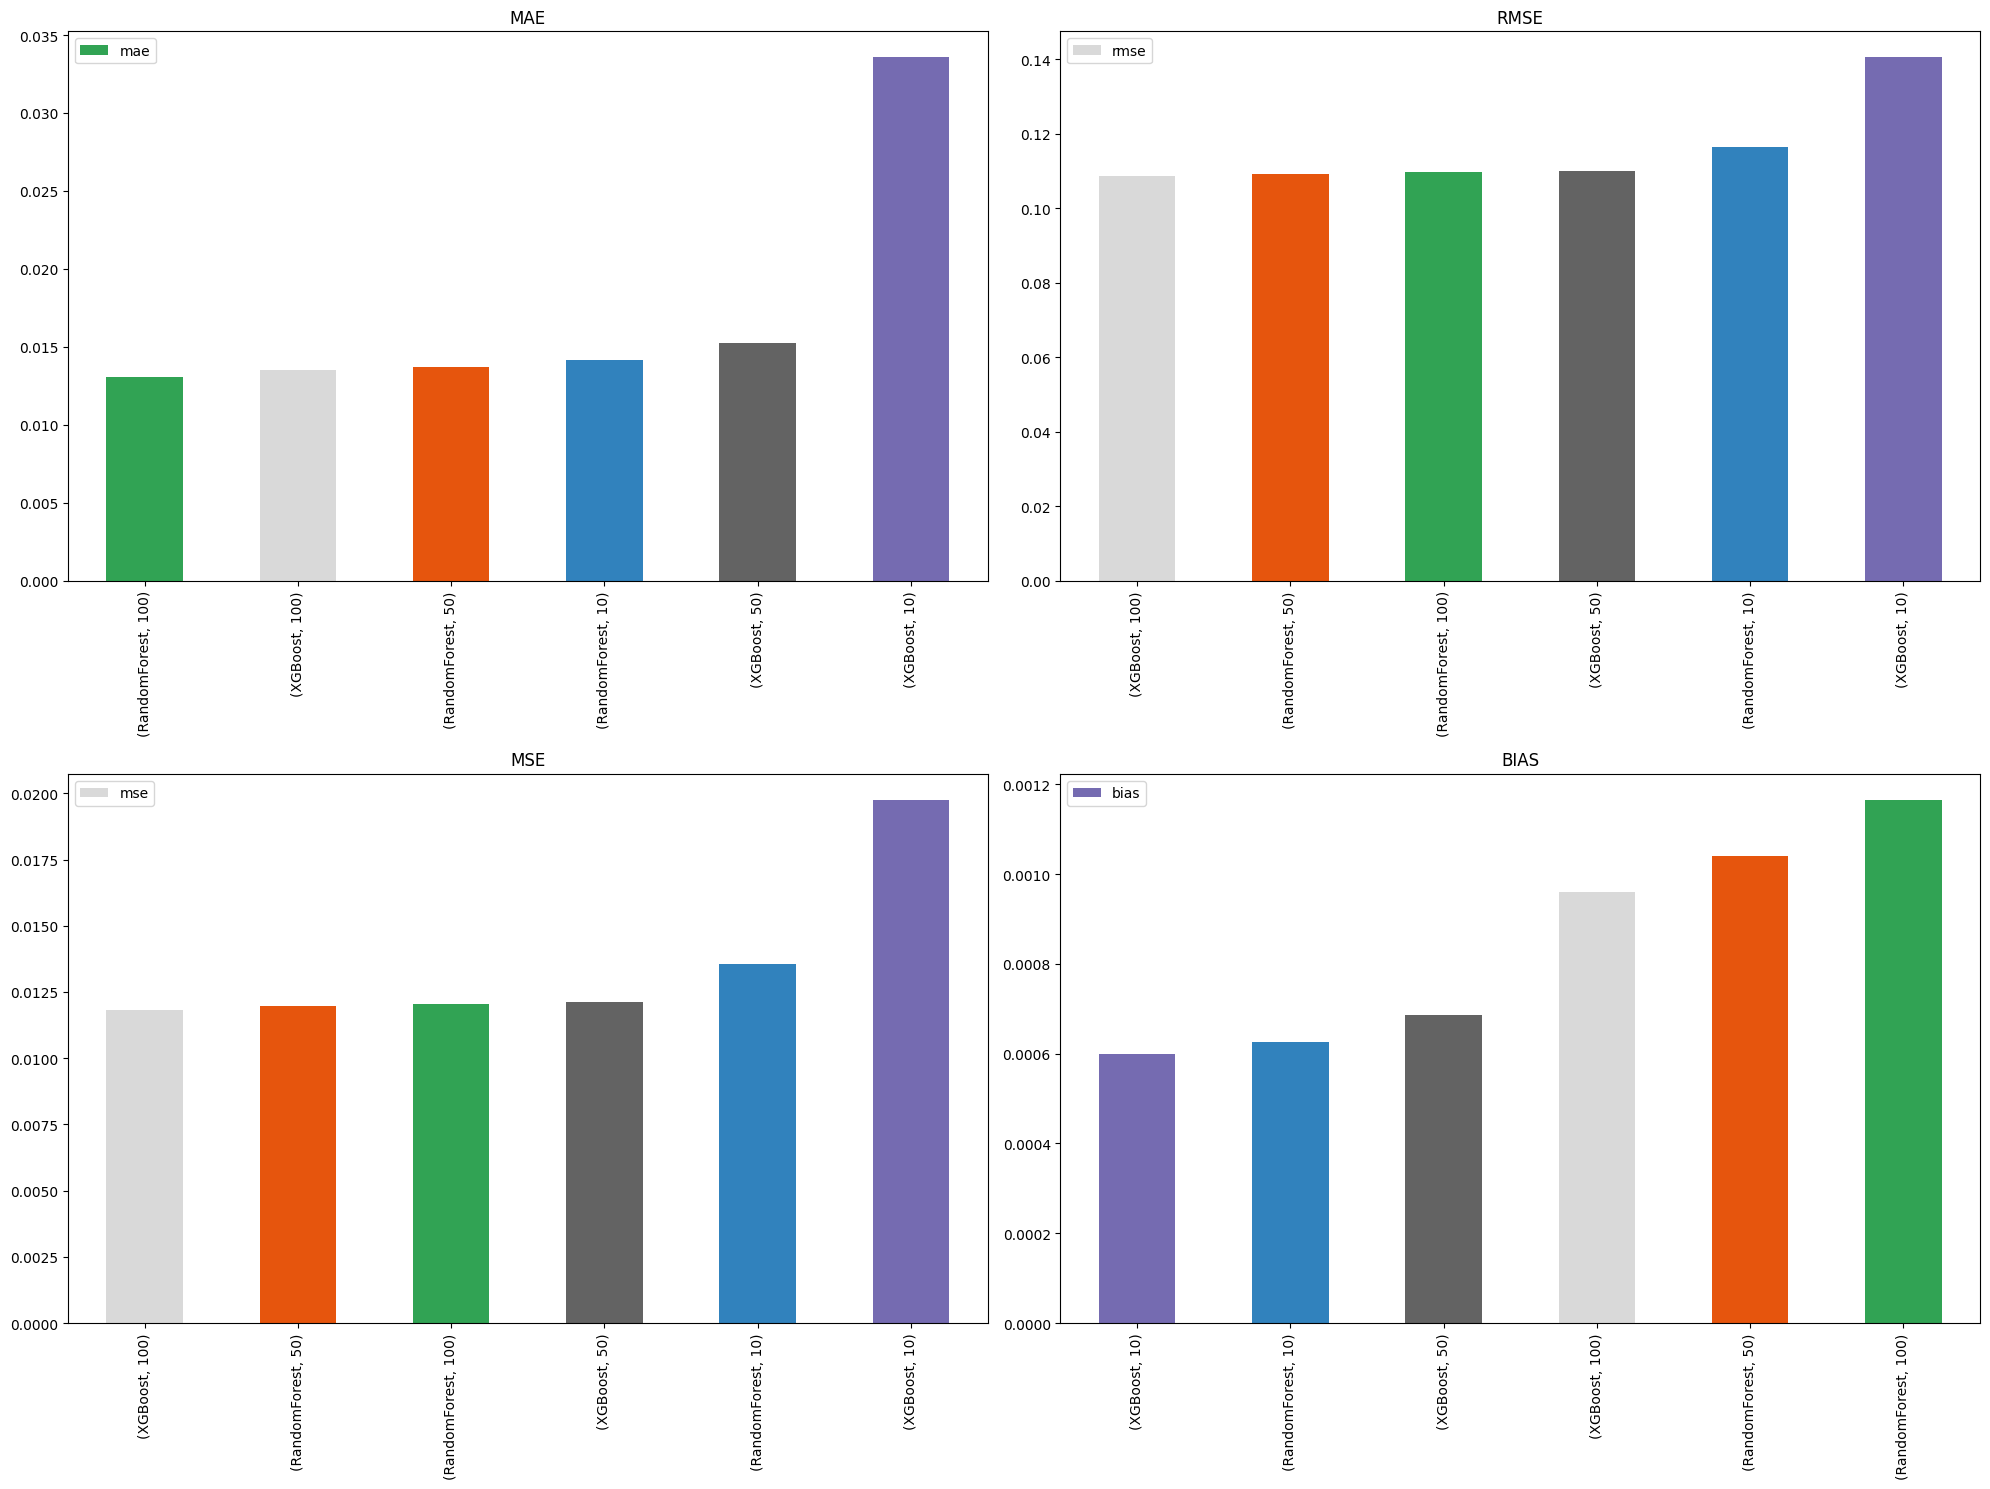

In [0]:
plot_bar_metrics(selected_results)

###  2. Statistical Tests for Feature Selection

#### Pearson Correlation Coefficient
Pearson Correlation Coefficient, often denoted as `r`, measures the strength and direction of a **linear relationship **between two continuous variables. It ranges from -1 to 1, where:

- `r==1` denotes a perfect positive linear relationship
- `r==-1` denotes a perfect negative linear relationship
- `r==0` denotes no relationship at all

In [0]:
from scipy.stats import pearsonr

def calculate_significance(df, target_column, dependent_columns):
    # Prepare the result list
    results = []

    # Extract the target values
    target_values = df[target_column]

    for column in dependent_columns:
        if column != target_column:
            # Extract the dependent variable values
            dependent_values = df[column]

            # Calculate Pearson correlation and p-value
            correlation, p_value = pearsonr(target_values, dependent_values)

            # Append the result as a tuple (Metric, Correlation, P-Value)
            results.append((column, correlation, p_value))

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Metric', 'Correlation', 'P-Value'])

    # Return the DataFrame sorted by absolute correlation value in descending order
    return results_df.sort_values(by='Correlation', key=abs, ascending=False)

# Usage example:
# Assuming your data is loaded in a DataFrame called df
dependent_columns = [
    "ActualPromoSalesVolumeSellOut", "ActualNetPromoNIVSellOut", "ActualNetPromoCOGSSellOut",
    "ActualNetPromoTOSellOut", "ActualPromoSalesValueSellOut", "ActualNetPromoGSVSellOut",
    "ActualBaselineVolume", "ActualEventSpend", "ActualTTSOffSpend", "ActualTTSOnSpend",
    "ActualBaselineValue", "ActualNetPromoGrossProfitsSellOut", "PlannedBaselineVolume",
    "ActualBaseNIVSellOut", "ActualBaseTOSellOut", "ActualBaseCOGSSellOut",
    "ActualBaseGSVSellOut", "ActualBaseGrossProfitsSellOut", "PlannedBaseTOSellIn",
    "PlannedBaseNIVSellIn", "PlannedBaseCOGSSellIn", "PlannedBaseGSVSellIn",
    "PlannedBaseGrossProfitsSellIn", "ActualBaseTTSOnSpend", "PlannedBaseTTSOnSpend",
    "ActualBaseTTSOffSpend", "ActualIGP", "TUEAN", "ListPrice", "PlannedBaseTTSOffSpend",
    "Level8Code", "InStoreEndWeek", "Year", "InStoreStartWeek", "Week"
]
target_column = 'ActualPromoSalesVolumeSellOut'

# Call the function
significance_df = calculate_significance(df, target_column, dependent_columns)

# Print the DataFrame (optional, if you want to see it in the console)
print(significance_df)

                               Metric  Correlation        P-Value
0            ActualNetPromoNIVSellOut     0.795623   0.000000e+00
1           ActualNetPromoCOGSSellOut     0.779996   0.000000e+00
2             ActualNetPromoTOSellOut     0.777515   0.000000e+00
3        ActualPromoSalesValueSellOut     0.774448   0.000000e+00
4            ActualNetPromoGSVSellOut     0.767759   0.000000e+00
5                ActualBaselineVolume     0.746398   0.000000e+00
6                    ActualEventSpend     0.651928   0.000000e+00
7                   ActualTTSOffSpend     0.641201   0.000000e+00
8                    ActualTTSOnSpend     0.635984   0.000000e+00
9                 ActualBaselineValue     0.633091   0.000000e+00
10  ActualNetPromoGrossProfitsSellOut     0.626196   0.000000e+00
11              PlannedBaselineVolume     0.612568   0.000000e+00
12               ActualBaseNIVSellOut     0.584809   0.000000e+00
13                ActualBaseTOSellOut     0.584597   0.000000e+00
14        

#### PCA - Principal Component Analysis
Principal component analysis, or PCA, is a **dimensionality reduction method** that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

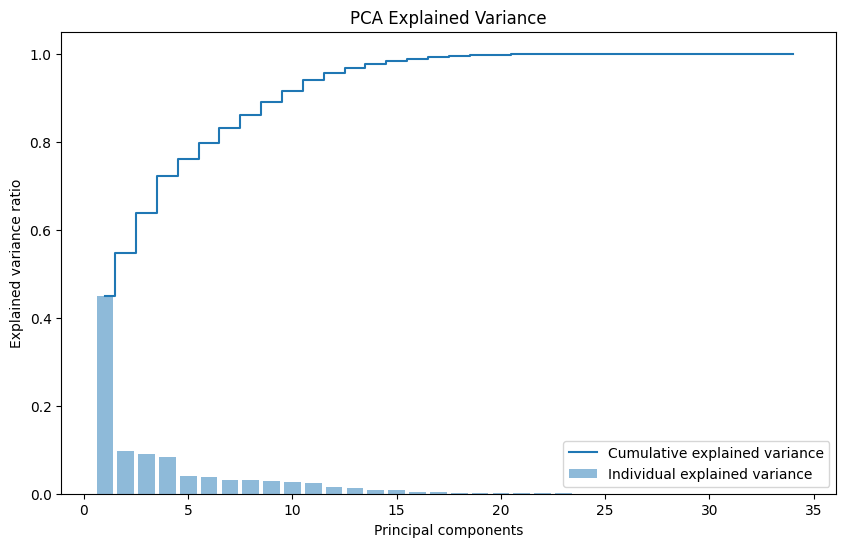

        PC1       PC2  ...          PC34  ActualPromoSalesVolumeSellOut
0  0.937816  1.962430  ...  7.555897e-13                         7143.0
1 -1.359333 -0.036033  ...  1.260160e-13                         1440.0
2 -1.549477  0.114530  ... -7.862204e-14                          966.0
3 -1.590636  0.142374  ...  6.177579e-14                          945.0
4 -1.351354 -0.282179  ... -1.497808e-13                         1706.0

[5 rows x 35 columns]
Explained Variance Ratio by each Principal Component:
PC1: 0.4504
PC2: 0.0964
PC3: 0.0904
PC4: 0.0844
PC5: 0.0392
PC6: 0.0371
PC7: 0.0322
PC8: 0.0303
PC9: 0.0290
PC10: 0.0266
PC11: 0.0253
PC12: 0.0143
PC13: 0.0122
PC14: 0.0087
PC15: 0.0074
PC16: 0.0047
PC17: 0.0031
PC18: 0.0024
PC19: 0.0021
PC20: 0.0012
PC21: 0.0011
PC22: 0.0006
PC23: 0.0005
PC24: 0.0005
PC25: 0.0000
PC26: 0.0000
PC27: 0.0000
PC28: 0.0000
PC29: 0.0000
PC30: 0.0000
PC31: 0.0000
PC32: 0.0000
PC33: 0.0000
PC34: 0.0000


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def perform_pca(df, dependent_columns, target_column):
    # Extract the features (independent variables)
    X = df[dependent_columns]

    # Standardize the features
    X_standardized = StandardScaler().fit_transform(X)

    # Perform PCA
    pca = PCA()
    principal_components = pca.fit_transform(X_standardized)

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(len(dependent_columns))])

    # Add the target variable to the DataFrame
    pca_df[target_column] = df[target_column]

    # Explained variance
    explained_variance = pca.explained_variance_ratio_

    # Plot the explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.title('PCA Explained Variance')
    plt.show()

    return pca_df, explained_variance

dependent_columns = [
    "ActualNetPromoNIVSellOut", "ActualNetPromoCOGSSellOut",
    "ActualNetPromoTOSellOut", "ActualPromoSalesValueSellOut", "ActualNetPromoGSVSellOut",
    "ActualBaselineVolume", "ActualEventSpend", "ActualTTSOffSpend", "ActualTTSOnSpend",
    "ActualBaselineValue", "ActualNetPromoGrossProfitsSellOut", "PlannedBaselineVolume",
    "ActualBaseNIVSellOut", "ActualBaseTOSellOut", "ActualBaseCOGSSellOut",
    "ActualBaseGSVSellOut", "ActualBaseGrossProfitsSellOut", "PlannedBaseTOSellIn",
    "PlannedBaseNIVSellIn", "PlannedBaseCOGSSellIn", "PlannedBaseGSVSellIn",
    "PlannedBaseGrossProfitsSellIn", "ActualBaseTTSOnSpend", "PlannedBaseTTSOnSpend",
    "ActualBaseTTSOffSpend", "ActualIGP", "TUEAN", "ListPrice", "PlannedBaseTTSOffSpend",
    "Level8Code", "InStoreEndWeek", "Year", "InStoreStartWeek", "Week"
]
target_column = 'ActualPromoSalesVolumeSellOut'

# Call the function
pca_df, explained_variance = perform_pca(df, dependent_columns, target_column)

# Display the first few rows of the PCA result DataFrame
print(pca_df.head())

# Display explained variance for each principal component
print("Explained Variance Ratio by each Principal Component:")
for i, var in enumerate(explained_variance):
    print(f'PC{i+1}: {var:.4f}')

#### Dimension Reduction
Dimensionality reduction is a technique used to **reduce the number of input variables** in your dataset. In essence, it simplifies the complexity without losing the essence of the information.

In [0]:
# Standardize the features
X = df[dependent_columns]
X_standardized = StandardScaler().fit_transform(X)

# Perform PCA with all components to get the loadings
pca = PCA()
pca.fit(X_standardized)

# Get the loadings
loadings = pca.components_.T

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=dependent_columns)

# Select the top 4 principal components
top_components_loadings = loadings_df[['PC1', 'PC2', 'PC3', 'PC4']]

# Display the loadings for the top 4 principal components
print(top_components_loadings)


                                        PC1       PC2       PC3       PC4
ActualNetPromoNIVSellOut           0.226852 -0.025946  0.235289 -0.095909
ActualNetPromoCOGSSellOut          0.222462 -0.022350  0.207058 -0.085164
ActualNetPromoTOSellOut            0.226595 -0.026894  0.211550 -0.087411
ActualPromoSalesValueSellOut       0.222046 -0.027598  0.231891 -0.087567
ActualNetPromoGSVSellOut           0.229264 -0.020991  0.220672 -0.088587
ActualBaselineVolume               0.186152 -0.186711 -0.165502  0.012367
ActualEventSpend                   0.168597 -0.039764  0.236108 -0.107816
ActualTTSOffSpend                  0.165640 -0.015523  0.254006 -0.099412
ActualTTSOnSpend                   0.207325 -0.010585  0.172076 -0.066719
ActualBaselineValue                0.223789 -0.199806 -0.117930  0.006537
ActualNetPromoGrossProfitsSellOut  0.189178 -0.028032  0.177489 -0.073876
PlannedBaselineVolume              0.165321  0.239121 -0.137597  0.091093
ActualBaseNIVSellOut               0.2

##### Summary of Best Features

> ActualNetPromoNIVSellOut, ActualNetPromoCOGSSellOut, ActualNetPromoTOSellOut, ActualPromoSalesValueSellOut, ActualNetPromoGSVSellOut: Strong influence on **PC1**.

> PlannedBaselineVolume, PlannedBaseTOSellIn, PlannedBaseNIVSellIn, PlannedBaseCOGSSellIn, PlannedBaseGSVSellIn: Strong influence on **PC2**.

> ActualIGP, InStoreEndWeek, Year, InStoreStartWeek: Strong influence on **PC3** and **PC4**.

# FAQs

- **Will the intermediate results be published in a leaderboard?**
  - Yes, a public leaderboard will be published to show the intermediate results for the forecast challenge for 50% of the data.

- **Which is the target? Is it ActualPromoSpend?**
  - The target variable is UK - ActualPromoSalesVolumeSellOut.
  - The target variable is Indo - ActualNetPromoSalesVolumeSellOut.

- **TUEAN column - which is one data point we should add into the final file is not in the Indonesia file. Is that OK? I could not find another matching column.**
  - The final file format would be slightly different between UK and Indonesia because the file format between the two countries is different - 
    - UK - PromoIDText x TUEAN x WeekSkID
    - Indo - Customer x PromoIDText x ProductNameSku_PPH x WeekSkID
